In [1]:
import os
import time
import random
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from utils import *
from models import ConvLSTM, PredRNNv2, SimVP, PhyDNet
# SimVPTEST: attSimVP-S
# SimVPTEST2: attSimVP-C
from proposal import SimVPCBAM, SimVPTEST, SimVPTEST2

In [3]:
# compare result
# ConvLSTM
with open('./save_models/ConvLSTM/train_loss.pkl', 'rb') as f:
    convlstm_train = pickle.load(f)
with open('./save_models/ConvLSTM/val_loss.pkl', 'rb') as f:
    convlstm_val = pickle.load(f)

# PredRNNv2
with open('./save_models/PredRNNv2/train_loss.pkl', 'rb') as f:
    predrnn_train = pickle.load(f)
with open('./save_models/PredRNNv2/val_loss.pkl', 'rb') as f:
    predrnn_val = pickle.load(f)

# PhyDNet
with open('./save_model/PhyDNet/train_loss.pkl', 'rb') as f:
    phydnet_train = pickle.load(f)
with open('./save_model/PhyDNet/val_loss.pkl', 'rb') as f:
    phydnet_val = pickle.load(f)

In [5]:
# SimVP
with open('./save_model/SimVP/train_loss.pkl', 'rb') as f:
    simvp_train = pickle.load(f)
with open('./save_model/SimVP/val_loss.pkl', 'rb') as f:
    simvp_val = pickle.load(f)
# AttSimVP-CBAM
with open('./save_model/SimVPCBAM/train_loss.pkl', 'rb') as f:
    simvpcbam_train = pickle.load(f)
with open('./save_model/SimVPCBAM/val_loss.pkl', 'rb') as f:
    simvpcbam_val = pickle.load(f)
# AttSimVP-S
with open('./save_model/SimVPSpatial/train_loss.pkl', 'rb') as f:
    simvptest_train = pickle.load(f)
with open('./save_model/SimVPSpatial/val_loss.pkl', 'rb') as f:
    simvptest_val = pickle.load(f)
# AttSimVP-C
with open('./save_model/SimVPChannel/train_loss.pkl', 'rb') as f:
    simvptest2_train = pickle.load(f)
with open('./save_model/SimVPChannel/val_loss.pkl', 'rb') as f:
    simvptest2_val = pickle.load(f)

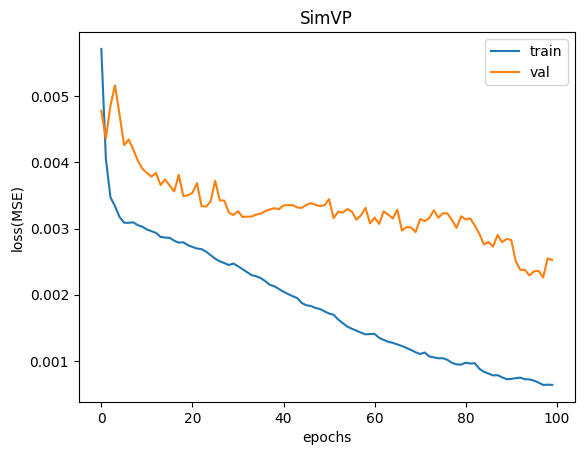

In [21]:
plt.title('SimVP')
plt.plot(simvp_train, label='train')
plt.plot(simvp_val, label='val')

plt.xlabel('epochs')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

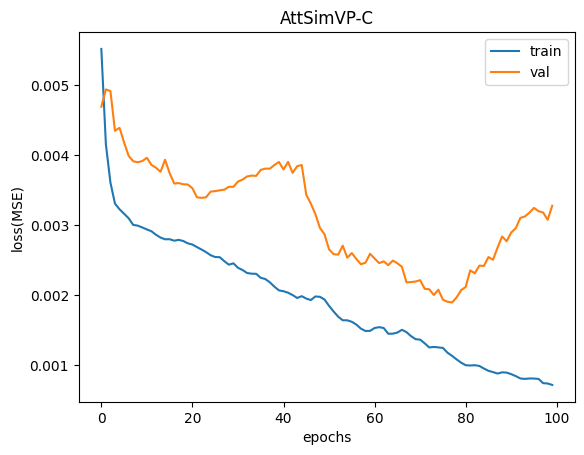

In [22]:
plt.title('AttSimVP-C')
plt.plot(simvptest2_train, label='train')
plt.plot(simvptest2_val, label='val')

plt.xlabel('epochs')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

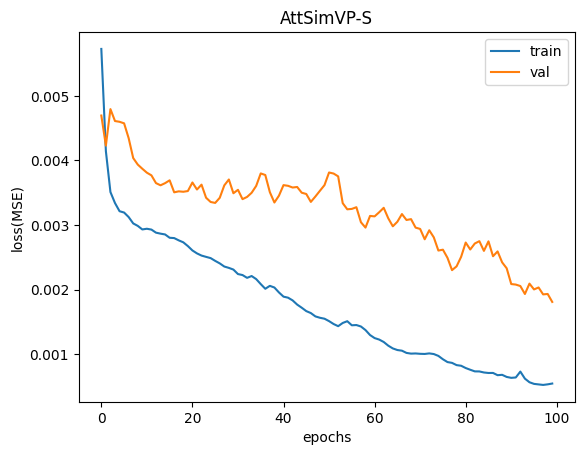

In [23]:
plt.title('AttSimVP-S')
plt.plot(simvptest_train, label='train')
plt.plot(simvptest_val, label='val')

plt.xlabel('epochs')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

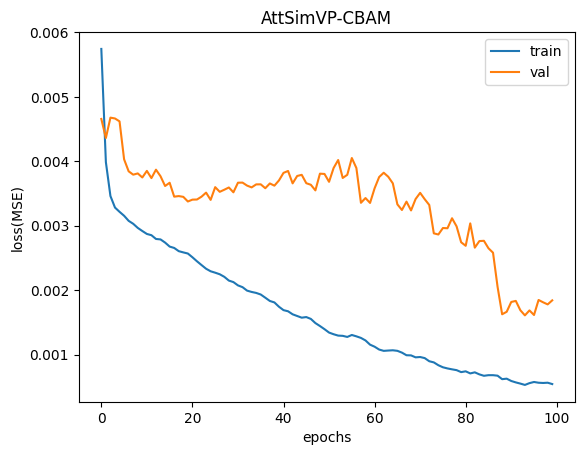

In [24]:
plt.title('AttSimVP-CBAM')
plt.plot(simvpcbam_train, label='train')
plt.plot(simvpcbam_val, label='val')

plt.xlabel('epochs')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

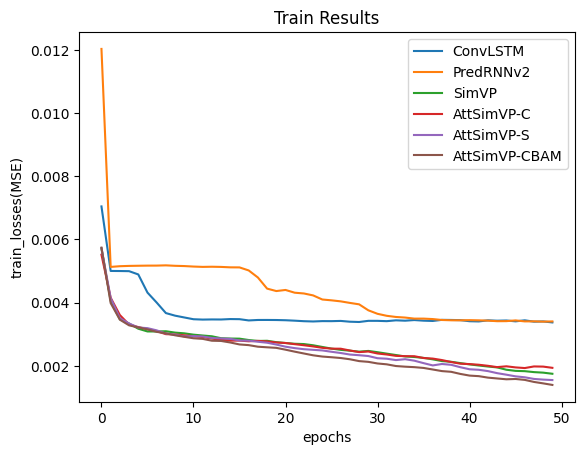

In [13]:
plt.title('Train Results')
plt.plot(convlstm_train[:50], label='ConvLSTM')
plt.plot(predrnn_train[:50], label='PredRNNv2')
# plt.plot(phydnet_train, label='PhyDNet')
plt.plot(simvp_train[:50], label='SimVP')
plt.plot(simvptest2_train[:50], label='AttSimVP-C')
plt.plot(simvptest_train[:50], label='AttSimVP-S')
plt.plot(simvpcbam_train[:50], label='AttSimVP-CBAM')


plt.xlabel('epochs')
plt.ylabel('train_losses(MSE)')
plt.legend()
plt.show()

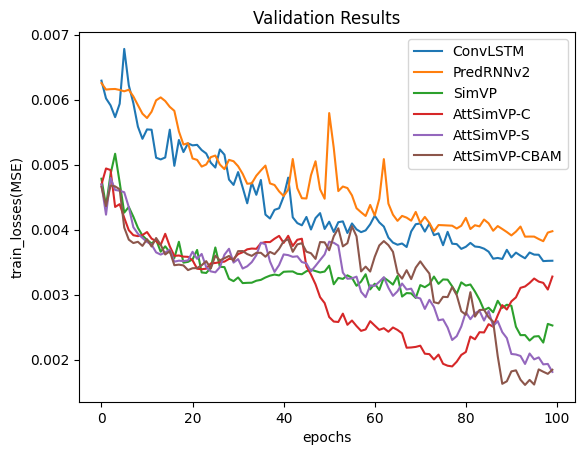

In [14]:
plt.title('Validation Results')
# plt.plot(convlstm_val[:50], label='ConvLSTM')
# plt.plot(predrnn_val[:50], label='PredRNNv2')
# # plt.plot(phydnet_train, label='PhyDNet')
# plt.plot(simvp_val[:50], label='SimVP')
# plt.plot(simvptest2_val[:50], label='AttSimVP-C')
# plt.plot(simvptest_val[:50], label='AttSimVP-S')
# plt.plot(simvpcbam_val[:50], label='AttSimVP-CBAM')

plt.plot(convlstm_val, label='ConvLSTM')
plt.plot(predrnn_val, label='PredRNNv2')
# plt.plot(phydnet_train, label='PhyDNet')
plt.plot(simvp_val, label='SimVP')
plt.plot(simvptest2_val, label='AttSimVP-C')
plt.plot(simvptest_val, label='AttSimVP-S')
plt.plot(simvpcbam_val, label='AttSimVP-CBAM')


plt.xlabel('epochs')
plt.ylabel('train_losses(MSE)')
plt.legend()
plt.show()

In [2]:
# evaluate
# ignore warning message
warnings.filterwarnings('ignore')

# fix seed
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
elec = np.expand_dims(np.load('./dataset/2d_elec.npy'), axis=1)
elec_x, elec_y, elec_val = make_sequential(elec)

train_X = elec_x[:(365*24*3)]
train_y = elec_y[:(365*24*3)]

val_X = elec_x[(365*24*3):(365*24*4)]
val_y = elec_y[(365*24*3):(365*24*4)]

test_X = elec_x[(365*24*4):]
test_y = elec_y[(365*24*4):]

In [4]:
train_dataset = CustomDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, 64, pin_memory=True)

val_dataset = CustomDataset(val_X, val_y)
val_loader = DataLoader(val_dataset, 64, pin_memory=True)

test_dataset = CustomDataset(test_X, test_y)
test_loader = DataLoader(test_dataset, 64, pin_memory=True)

In [5]:
X, _ = next(iter(train_loader))

In [6]:
ConvLSTM = ConvLSTM(num_layers=3, num_hidden=[128,128,128], shape=X.shape[1:], kernel_size=5, stride=1)
ConvLSTM.load_state_dict(torch.load('./save_models/ConvLSTM/best_ConvLSTM_47.pth'))

PredRNNv2 = PredRNNv2(num_layers=3, num_hidden=[128,128,128], shape=X.shape[1:], kernel_size=5, stride=1)
PredRNNv2.load_state_dict(torch.load('./save_models/PredRNNv2/best_PredRNNv2_50.pth'))

device = torch.device('cuda')
phycell = PhyDNet.PhyCell(input_shape=(2, 5), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7, 7),
                          device=device)
convcell = PhyDNet.ConvLSTM(input_shape=(2, 5), input_dim=64, hidden_dims=[128, 128, 64], n_layers=3,
                            kernel_size=(3, 3), device=device)
PhyDNet = PhyDNet.EncoderRNN(phycell, convcell, device)
PhyDNet.load_state_dict(torch.load('./save_model/PhyDNet/best_PhyDNet_47.pth'))

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


<All keys matched successfully>

In [55]:
simvp = SimVP(X.shape[1:])
simvp.load_state_dict(torch.load('./save_model/SimVP/best_SimVP_32.pth'))

attsimvpC = SimVPTEST2(X.shape[1:])
attsimvpC.load_state_dict(torch.load('./save_model/SimVPChannel/best_SimVPChannel_50.pth'))

attsimvpS = SimVPTEST(X.shape[1:])
attsimvpS.load_state_dict(torch.load('./save_model/SimVPSpatial/best_SimVPSpatial_26.pth'))

simvpCBAM = SimVPCBAM(X.shape[1:])
simvpCBAM.load_state_dict(torch.load('./save_model/SimVPCBAM/best_SimVPCBAM_58.pth'))

<All keys matched successfully>

In [44]:
from tqdm import tqdm

def test_eval(model, test_loader):
    re_normalize = 147.0411963816698
    mseloss = nn.MSELoss()
    maeloss = nn.L1Loss()
    
    model.eval()
    with torch.no_grad():
        test_mse = 0
        test_mae = 0
        for data in tqdm(test_loader):
            X, Y = data
            Y *= re_normalize
            preds = model(X) * re_normalize
            
            mse = mseloss(preds, Y)
            mae = maeloss(preds, Y)            
            
            test_mse += (mse/len(test_loader))
            test_mae += (mae/len(test_loader))
    return test_mse, test_mae

In [66]:
test_mse, test_mae = test_eval(ConvLSTM, test_loader)

100%|██████████| 56/56 [01:40<00:00,  1.80s/it]


In [67]:
test_mse, test_mae

(tensor(59.0129), tensor(3.6620))

In [69]:
test_mse2, test_mae2 = test_eval(PredRNNv2, test_loader)

100%|██████████| 56/56 [03:35<00:00,  3.85s/it]


In [70]:
test_mse2, test_mae2

(tensor(61.4595), tensor(4.3686))

In [ ]:
def evaluate(encoder, loader):
    total_mse, total_mae = 0, 0
    t0 = time.time()
    with torch.no_grad():
        for i, out in enumerate(loader, 0):
            input_tensor = out[0].to(device)
            target_tensor = out[1].to(device)
            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length - 1):
                encoder_output, encoder_hidden, _, _, _ = encoder(input_tensor[:, ei, :, :, :], (ei == 0))

            decoder_input = input_tensor[:, -1, :, :, :]  # first decoder input= last image of input sequence
            predictions = []

            for di in range(target_length):
                decoder_output, decoder_hidden, output_image, _, _ = encoder(decoder_input, False, False)
                decoder_input = output_image
                predictions.append(output_image.cpu())

            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            target *= 147.0411963816698
            predictions = np.stack(predictions)  # (10, batch_size, 1, 64, 64)
            predictions = predictions.swapaxes(0, 1)  # (batch_size,10, 1, 64, 64)
            predictions *= 147.0411963816698

            mse_batch = np.mean((predictions - target) ** 2, axis=(0, 1, 2)).sum()
            mae_batch = np.mean(np.abs(predictions - target), axis=(0, 1, 2)).sum()
            total_mse += mse_batch
            total_mae += mae_batch

            # for a in range(0,target.shape[0]):
            #     for b in range(0,target.shape[1]):
            #         total_ssim += ssim(target[a,b,0,], predictions[a,b,0,]) / (target.shape[0]*target.shape[1]) 

    # print('eval mse ', total_mse / len(loader), ' eval mae ', total_mae / len(loader), ' time= ', time.time() - t0)
    return total_mse / len(loader), total_mae / len(loader)

In [ ]:
test_mse3, test_mae3 = evaluate(PhyDNet, test_loader)